# Extracción de caracteristicas proyecto:
# Clasificación de supernovas de ALeRCE - ZTF
### Por Joaquin Zepeda y Benjamin Irarrazabal - Tutor: Pablo Montero

#Bloque Inicial
Ejecutar una vez y luego reiniciar el entorno de ejecución

In [ ]:
# pyarrow might be needed to read the data
!python -m pip install Cython
!python -m pip install -e git+https://git@github.com/alercebroker/turbo-fats#egg=turbofats
!python -m pip install -e git+https://git@github.com/alercebroker/mhps#egg=mhps
!python -m pip install -e git+https://git@github.com/alercebroker/P4J#egg=P4J
!python -m pip install pyarrow
!python -m pip install -e git+https://git@github.com/alercebroker/lc_classifier#egg=lc_classifier

#Bloques Principales
Luego de realizar el paso previo, se pueden ejecutar uno a uno los siguientes bloques

In [ ]:
import numpy as np
import pandas as pd
from lc_classifier.features import ZTFLightcurvePreprocessor, ZTFFeatureExtractor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Importamos los extractores de caracteristicas

In [ ]:
from lc_classifier.features import SupernovaeDetectionFeatureExtractor, SNParametricModelExtractor, IQRExtractor,MHPSExtractor

# Leyendo los datos
La idea es seleccionar los dos archivos CSV que contienen los datos: 

1- detections_SNe_v7.0.1.csv

2- dfcrossmatches_prioritized_v7.0.1.csv

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving detections_SNe_v7.0.1.csv to detections_SNe_v7.0.1.csv
Saving dfcrossmatches_prioritized_v7.0.1.csv to dfcrossmatches_prioritized_v7.0.1.csv


In [ ]:
import io
detections = pd.read_csv(io.StringIO(uploaded['detections_SNe_v7.0.1.csv'].decode('utf-8')), index_col=None)
dfcrossmatches = pd.read_csv(io.StringIO(uploaded['dfcrossmatches_prioritized_v7.0.1.csv'].decode('utf-8')), index_col=None)

# Union de tablas
Se realiza un Join con el fin de tener además de los nombres de los objetos, la clase a la cual pertenece, tendremos algunas columnas extras las cuales serán eliminadas más tarde

In [ ]:
Conjunto = pd.merge(detections, dfcrossmatches, left_on='objectId', right_on='oid')

In [ ]:
Conjunto.head()

,Unnamed: 0,objectId,fid,isdiffpos,sigmapsf,field,fwhm,dec_x,magpsf,rcid,ra_x,sky,rb,ssmagnr,distpsnr3,sgscore2,maggaiabright,distpsnr2,distpsnr1,maggaia,exptime,drb,sgscore3,neargaia,sgscore1,mjd,corrected,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext,dubious,has_stamp,oid,classALeRCE,ra_y,dec_y,period,source,id_source,class_source,separation_arcsec
0,0,ZTF18aahvndq,1,1.0,0.028791,626,3.59,27.008621,15.385100,34,198.722678,-0.101586,0.770000,-999.0,21.691795,0.001667,-999.0,21.650759,1.984529,17.138538,30.0,0.999970,0.5,78.019280,0.175976,58991.302095,False,NaN,NaN,NaN,False,True,ZTF18aahvndq,SNIa,198.722653,27.008637,NaN,TNS,SN 2020jhf,SN Ia,0.103069
1,1,ZTF18aahvndq,1,1.0,0.031231,626,2.57,27.008635,15.712121,34,198.722679,-0.217021,0.894286,-999.0,21.712288,0.001667,-999.0,21.672073,2.034691,17.138538,30.0,0.999996,0.5,78.022800,0.175976,59000.260914,False,NaN,NaN,NaN,False,True,ZTF18aahvndq,SNIa,198.722653,27.008637,NaN,TNS,SN 2020jhf,SN Ia,0.103069
2,2,ZTF18aahvndq,1,1.0,0.032161,626,1.98,27.008647,16.072975,34,198.722653,-1.455619,0.907143,-999.0,21.647310,0.001667,-999.0,21.608295,2.075565,17.138538,30.0,0.999939,0.5,78.111310,0.175976,59004.192674,False,NaN,NaN,NaN,False,True,ZTF18aahvndq,SNIa,198.722653,27.008637,NaN,TNS,SN 2020jhf,SN Ia,0.103069
3,3,ZTF18aahvndq,1,1.0,0.049931,626,2.75,27.008624,17.708502,34,198.722660,0.167642,0.947143,-999.0,21.641445,0.001667,-999.0,21.600946,1.995552,17.138538,30.0,0.999956,0.5,78.077545,0.175976,59021.227604,False,NaN,NaN,NaN,False,True,ZTF18aahvndq,SNIa,198.722653,27.008637,NaN,TNS,SN 2020jhf,SN Ia,0.103069
4,4,ZTF18aahvndq,1,1.0,0.028520,626,3.13,27.008636,15.617474,34,198.722660,0.027993,0.837143,-999.0,21.656885,0.001667,-999.0,21.617119,2.039114,17.138538,30.0,0.999770,0.5,78.083150,0.175976,58986.223646,False,NaN,NaN,NaN,False,True,ZTF18aahvndq,SNIa,198.722653,27.008637,NaN,TNS,SN 2020jhf,SN Ia,0.103069


In [ ]:
# Le hacemos un slicing al conjunto:
slice_cjto = Conjunto[['classALeRCE','oid','objectId','isdiffpos','magpsf','mjd','magpsf_corr','sigmapsf','sigmapsf_corr','fid']]
slice_cjto.head() # Printeamos las primeras filas del conjunto para observar que se hayan tomado bien los datos

,classALeRCE,oid,objectId,isdiffpos,magpsf,mjd,magpsf_corr,sigmapsf,sigmapsf_corr,fid
0,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,15.385100,58991.302095,NaN,0.028791,NaN,1
1,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,15.712121,59000.260914,NaN,0.031231,NaN,1
2,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,16.072975,59004.192674,NaN,0.032161,NaN,1
3,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,17.708502,59021.227604,NaN,0.049931,NaN,1
4,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,15.617474,58986.223646,NaN,0.028520,NaN,1


# Limpieza de datos: 
Se quitan los registros que se detecten como outliers, estos corresponderian a los que se alejan a más de 3 desviaciones estandar del promedio.

In [ ]:
from scipy import stats
clean_data = slice_cjto[((np.abs(stats.zscore(slice_cjto['magpsf']))<3)&(slice_cjto['sigmapsf']<1))]

In [ ]:
clean_data.head()

,classALeRCE,oid,objectId,isdiffpos,magpsf,mjd,magpsf_corr,sigmapsf,sigmapsf_corr,fid
2,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,16.072975,59004.192674,NaN,0.032161,NaN,1
3,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,17.708502,59021.227604,NaN,0.049931,NaN,1
6,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,16.626165,59009.258669,NaN,0.044748,NaN,1
8,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,18.192377,59036.198090,NaN,0.078094,NaN,1
9,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,18.481302,59045.238090,NaN,0.083104,NaN,1


# Se arreglan los NaN que aparecen en magpsf_corr y sigmapsf_corr copiando el valor que tienen en sus versiones no corregidas.

In [ ]:
n = len(clean_data)
copy_cleandata = clean_data.copy()

for i in range(0,n):
  if pd.isna(clean_data.iloc[i,8]) == True:
    copy_cleandata.iloc[i,8] = copy_cleandata.iloc[i,7]
  else:
    pass
for i in range(0,n):
  if pd.isna(clean_data.iloc[i,6]) == True:
    copy_cleandata.iloc[i,6] = copy_cleandata.iloc[i,4]
  else:
    pass

In [ ]:
copy_cleandata.head()

,classALeRCE,oid,objectId,isdiffpos,magpsf,mjd,magpsf_corr,sigmapsf,sigmapsf_corr,fid
2,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,16.072975,59004.192674,16.072975,0.032161,0.032161,1
3,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,17.708502,59021.227604,17.708502,0.049931,0.049931,1
6,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,16.626165,59009.258669,16.626165,0.044748,0.044748,1
8,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,18.192377,59036.198090,18.192377,0.078094,0.078094,1
9,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,18.481302,59045.238090,18.481302,0.083104,0.083104,1


#Calculamos la cantidad de supernovas que hay en la base de datos

In [ ]:
# tomamos un subslice de los datos tomando solo la columna del Id con la de la clase:
subslice = clean_data[['objectId','classALeRCE']]
# Ahora, a este subslice, le eliminamos los "duplicados" de cada curva para poder obtener la cantidad de supernovas que tenemos
subslice_sinduplicados = subslice.drop_duplicates(subset=['objectId'])
# Y ahora que ya tenemos esto, podemos calcular la cantidad de supernovas real que hay, es decir, tomando solo 1 muestra para c/u
subslice_sinduplicados.groupby('classALeRCE').count()


,objectId
classALeRCE,
SLSN,34
SNII,330
SNIIb,16
SNIIn,42
SNIa,1540
SNIbc,106


<AxesSubplot:xlabel='classALeRCE'>

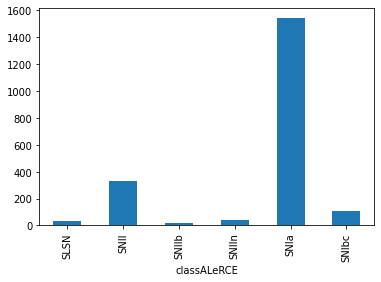

In [ ]:
group_cleandata = subslice_sinduplicados.groupby('classALeRCE')['classALeRCE'].count()
group_cleandata.plot(kind='bar')

# Se le cambia el nombre a los datos solo por conveniencia, los datos a utilizar ya filtrados corresponden a "Datos_Final"

In [ ]:
# Ahora, tomaremos un ejemplo de cada supernova y graficaremos su curva de luz.
Datos_Final = copy_cleandata #Las muestras con los NaN reemplazados y sin outliers

#Se grafica un ejemplo de curva de luz por cada tipo de supernova

In [ ]:
# Ahora comenzamos a tomar datos para las curvas de luz, como son 6 tipos de curvas de luz haremos 1 ejemplo de cada una (ie, 6 curvas)
import matplotlib.pyplot as plt
Curva_SNIa = Datos_Final.loc[Datos_Final.loc[:,'oid']=='ZTF20aaxxcms'] # SNIa
Curva_SNII = Datos_Final.loc[Datos_Final.loc[:,'oid']=='ZTF19abhduuo'] # SNII
Curva_SLSN = Datos_Final.loc[Datos_Final.loc[:,'oid']=='ZTF19aalbrgu'] # SLSN
Curva_SNIIb = Datos_Final.loc[Datos_Final.loc[:,'oid']=='ZTF19aaejtof'] # SNIIb
Curva_SNIIn = Datos_Final.loc[Datos_Final.loc[:,'oid']=='ZTF19abgndlf'] # SNIIn
Curva_SNIbc = Datos_Final.loc[Datos_Final.loc[:,'oid']=='ZTF19abqwtfu'] # SNIbc


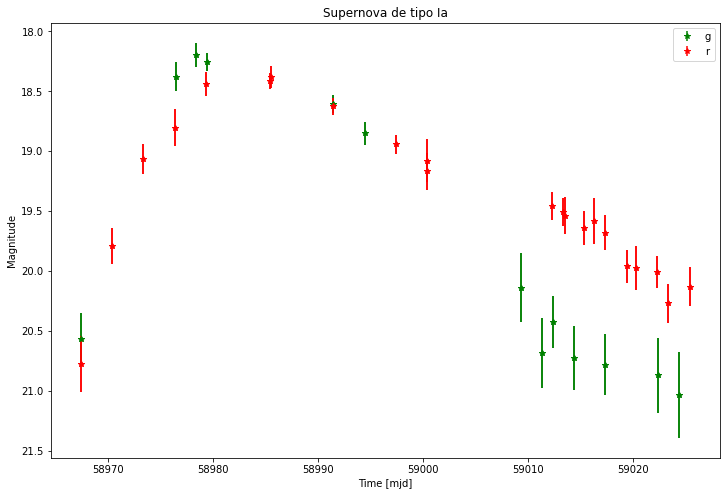

In [ ]:
# GRAFICAMOS LA CURVA PARA LA SUPERNOVA TIPO Ia
lc_g_SNIa = Curva_SNIa[Curva_SNIa.fid == 1]
lc_r_SNIa = Curva_SNIa[Curva_SNIa.fid == 2]
fig = plt.figure(figsize=(12, 8))
fig.set_facecolor('white')

plt.errorbar(lc_g_SNIa['mjd'], lc_g_SNIa['magpsf_corr'], yerr=lc_g_SNIa['sigmapsf_corr'], fmt='*g', label='g')
plt.errorbar(lc_r_SNIa['mjd'], lc_r_SNIa['magpsf_corr'], yerr=lc_r_SNIa['sigmapsf_corr'], fmt='*r', label='r')
plt.xlabel('Time [mjd]')
plt.ylabel('Magnitude')
plt.title('Supernova de tipo Ia')
plt.legend()
plt.gca().invert_yaxis()

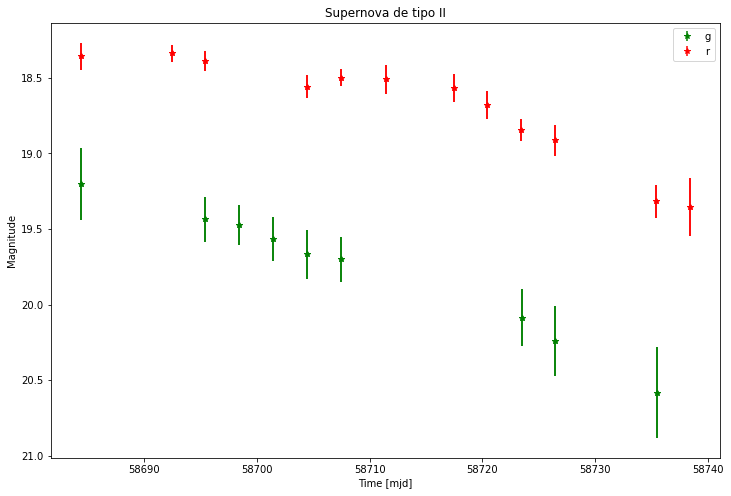

In [ ]:
# GRAFICAMOS LA CURVA PARA LA SUPERNOVA DE TIPO II
lc_g_SNII = Curva_SNII[Curva_SNII.fid == 1]
lc_r_SNII = Curva_SNII[Curva_SNII.fid == 2]
fig = plt.figure(figsize=(12, 8))
fig.set_facecolor('white')

plt.errorbar(lc_g_SNII['mjd'], lc_g_SNII['magpsf_corr'], yerr=lc_g_SNII['sigmapsf_corr'], fmt='*g', label='g')
plt.errorbar(lc_r_SNII['mjd'], lc_r_SNII['magpsf_corr'], yerr=lc_r_SNII['sigmapsf_corr'], fmt='*r', label='r')
plt.xlabel('Time [mjd]')
plt.ylabel('Magnitude')
plt.title('Supernova de tipo II')
plt.legend()
plt.gca().invert_yaxis()

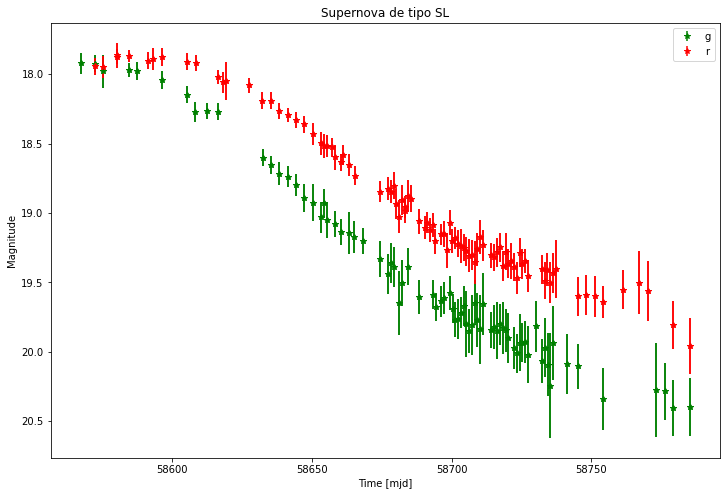

In [ ]:
# GRAFICAMOS LA CURVA PARA LA SUPERNOVA DE TIPO SL
lc_g_SLSN = Curva_SLSN[Curva_SLSN.fid == 1]
lc_r_SLSN = Curva_SLSN[Curva_SLSN.fid == 2]
fig = plt.figure(figsize=(12, 8))
fig.set_facecolor('white')

plt.errorbar(lc_g_SLSN['mjd'], lc_g_SLSN['magpsf_corr'], yerr=lc_g_SLSN['sigmapsf_corr'], fmt='*g', label='g')
plt.errorbar(lc_r_SLSN['mjd'], lc_r_SLSN['magpsf_corr'], yerr=lc_r_SLSN['sigmapsf_corr'], fmt='*r', label='r')
plt.xlabel('Time [mjd]')
plt.ylabel('Magnitude')
plt.title('Supernova de tipo SL')
plt.legend()
plt.gca().invert_yaxis()

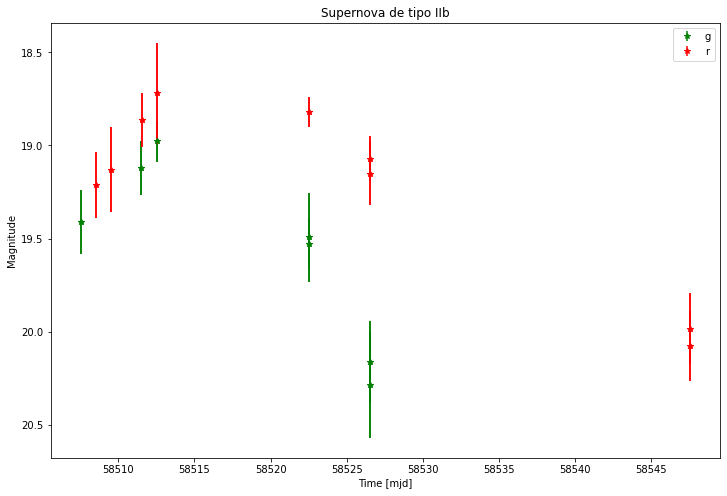

In [ ]:
# GRAFICAMOS LA CURVA PARA LA SUPERNOVA DE TIPO IIb
lc_g_SNIIb = Curva_SNIIb[Curva_SNIIb.fid == 1]
lc_r_SNIIb = Curva_SNIIb[Curva_SNIIb.fid == 2]
fig = plt.figure(figsize=(12, 8))
fig.set_facecolor('white')

plt.errorbar(lc_g_SNIIb['mjd'], lc_g_SNIIb['magpsf_corr'], yerr=lc_g_SNIIb['sigmapsf_corr'], fmt='*g', label='g')
plt.errorbar(lc_r_SNIIb['mjd'], lc_r_SNIIb['magpsf_corr'], yerr=lc_r_SNIIb['sigmapsf_corr'], fmt='*r', label='r')
plt.xlabel('Time [mjd]')
plt.ylabel('Magnitude')
plt.title('Supernova de tipo IIb')
plt.legend()
plt.gca().invert_yaxis()

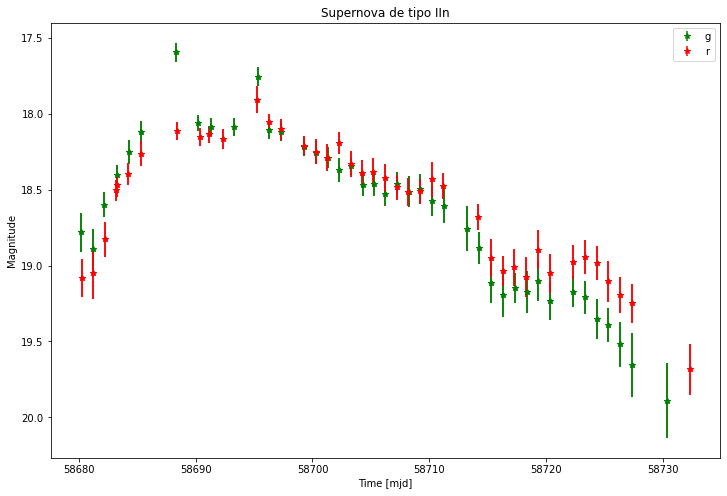

In [ ]:
# GRAFICAMOS LA CURVA PARA LA SUPERNOVA DE TIPO IIn
lc_g_SNIIn = Curva_SNIIn[Curva_SNIIn.fid == 1]
lc_r_SNIIn = Curva_SNIIn[Curva_SNIIn.fid == 2]
fig = plt.figure(figsize=(12, 8))
fig.set_facecolor('white')

plt.errorbar(lc_g_SNIIn['mjd'], lc_g_SNIIn['magpsf_corr'], yerr=lc_g_SNIIn['sigmapsf_corr'], fmt='*g', label='g')
plt.errorbar(lc_r_SNIIn['mjd'], lc_r_SNIIn['magpsf_corr'], yerr=lc_r_SNIIn['sigmapsf_corr'], fmt='*r', label='r')
plt.xlabel('Time [mjd]')
plt.ylabel('Magnitude')
plt.title('Supernova de tipo IIn')
plt.legend()
plt.gca().invert_yaxis()

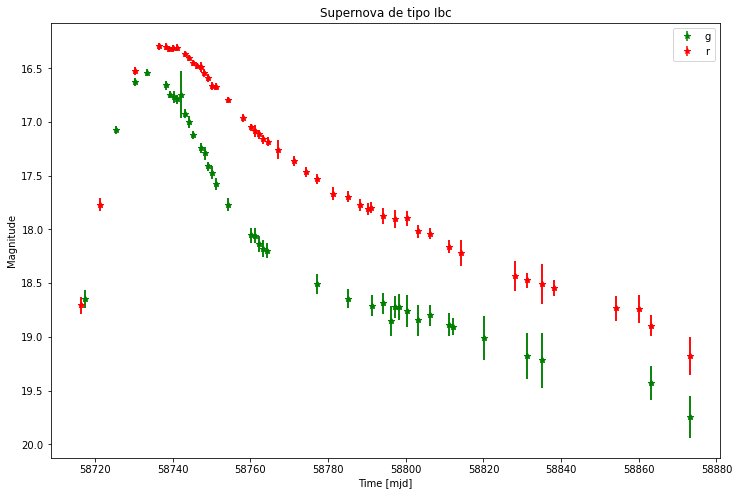

In [ ]:
# GRAFICAMOS LA CURVA PARA LA SUPERNOVA DE TIPO Ibc
lc_g_SNIbc = Curva_SNIbc[Curva_SNIbc.fid == 1]
lc_r_SNIbc = Curva_SNIbc[Curva_SNIbc.fid == 2]
fig = plt.figure(figsize=(12, 8))
fig.set_facecolor('white')

plt.errorbar(lc_g_SNIbc['mjd'], lc_g_SNIbc['magpsf_corr'], yerr=lc_g_SNIbc['sigmapsf_corr'], fmt='*g', label='g')
plt.errorbar(lc_r_SNIbc['mjd'], lc_r_SNIbc['magpsf_corr'], yerr=lc_r_SNIbc['sigmapsf_corr'], fmt='*r', label='r')
plt.xlabel('Time [mjd]')
plt.ylabel('Magnitude')
plt.title('Supernova de tipo Ibc')
plt.legend()
plt.gca().invert_yaxis()

# Extracción de características preliminar

In [ ]:
#----------------------------SupernovaeDetectionFeatureExtractor-------------------------------------------------------
# detections_df has missing columns: SupernovaeDetectionFeatureExtractor requires ('isdiffpos', 'magnitude', 'time', 'band')
#Le cambiamos los nombres a las columnas correspondientes pues este extractor necesita de estas columnas para funcionar
detections_df= Datos_Final .rename(columns={'magpsf':'magnitude','mjd':'time', 'fid':'band'})
feature_extractor = SupernovaeDetectionFeatureExtractor(bands=(1, 2))
features = feature_extractor.compute_features(detections = detections_df)

#----------------------------IQREXTRACTOR------------------------------------------------------------------------------

detections_df3 = Datos_Final.rename(columns={'magpsf':'magnitude','mjd':'time', 'fid':'band'})
feature_extractor3 = IQRExtractor(bands=(1, 2))
features3 = feature_extractor3.compute_features(detections = detections_df3)

df = features.join(features3)

In [ ]:
df

,delta_mag_fid_1,delta_mjd_fid_1,first_mag_1,mean_mag_1,min_mag_1,n_det_1,n_neg_1,n_pos_1,positive_fraction_1,delta_mag_fid_2,delta_mjd_fid_2,first_mag_2,mean_mag_2,min_mag_2,n_det_2,n_neg_2,n_pos_2,positive_fraction_2,iqr_1,iqr_2
oid,,,,,,,,,,,,,,,,,,,,
ZTF17aadlxmv,2.244800,42.055613,19.879980,19.087656,17.947500,18.0,0.0,18.0,1.0,1.847730,48.854525,19.799040,18.540755,17.951310,36.0,0.0,36.0,1.0,0.946885,0.657760
ZTF18aaaqexr,0.896138,18.870671,19.133900,18.977915,18.447520,9.0,0.0,9.0,1.0,0.191736,10.058981,18.633383,18.729251,18.633383,2.0,0.0,2.0,1.0,0.487402,0.095868
ZTF18aacdbzx,0.495977,19.991725,19.741877,19.620142,19.432064,14.0,0.0,14.0,1.0,0.786995,27.982234,19.321800,19.284748,19.027960,20.0,0.0,20.0,1.0,0.268495,0.257782
ZTF18aadmssd,3.293953,59.951100,16.887047,18.581230,16.887047,16.0,0.0,16.0,1.0,2.170098,76.909931,16.508772,17.551116,16.508772,30.0,0.0,30.0,1.0,1.525995,0.901432
ZTF18aadzfso,1.371363,32.999224,19.840900,19.273643,18.476837,24.0,0.0,24.0,1.0,0.797367,36.979248,19.220867,18.851365,18.423500,30.0,0.0,30.0,1.0,0.784556,0.338915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20abgbxfm,2.981503,68.950197,18.893476,19.555296,18.296597,58.0,0.0,58.0,1.0,2.216758,69.925914,18.943254,19.493850,18.398882,76.0,0.0,76.0,1.0,1.599315,1.306183
ZTF20abgdtmv,2.669654,33.020729,18.728144,20.046770,18.663546,26.0,0.0,26.0,1.0,1.719614,41.949225,19.138718,19.480131,18.640238,40.0,0.0,40.0,1.0,1.793608,0.759853
ZTF20abgfekk,1.627867,31.928044,19.095242,17.742374,17.467375,32.0,0.0,32.0,1.0,1.534458,31.981505,19.148731,17.866029,17.614273,40.0,0.0,40.0,1.0,0.298659,0.155161


In [ ]:
#----------------------------SNParametricModelExtractor----------------------------POR REVISAR--------------------------------------------------
# Atributos requeridos para ocupar el segundo extractor de caracteristicas: SNParametricModelExtractor
# "diff_flux", "diff_err", "time", "band", "magnitude"
# Falta comporbar que efectivamente el dataframe detections_df2 cuente con esas columnas
detections_df2= Datos_Final.rename(columns={'mjd':'time', 'fid':'band'})
feature_extractor2 = SNParametricModelExtractor(bands=(1, 2))
features2 = feature_extractor2.compute_features(detections = detections_df2)

In [ ]:
df = df.reset_index()

# Separación del conjunto en ENTRENAMIENTO y TEST: 
Dividiremos el conjunto en 70% para entrenamiento y 30% para test

In [ ]:
from sklearn.utils import shuffle

#Datos_Final.set_index("objectId", inplace = True)

#--------------------le agregamos la clase que le corresponde a cada registro---------------------------
df_con_target = pd.merge(df, dfcrossmatches[['oid','classALeRCE']], left_on='oid', right_on='oid')

#--------------------Mezclamos los datos de tal manera de poder tomar muestras representativas del conjunto-----------------
df_shuffle = shuffle(df_con_target)

#--------------------Eliminamos los NaN en caso de que aun queden -------------------------------------------------
df_shuffle = df_shuffle.dropna()

In [ ]:
df_shuffle.head()

,oid,delta_mag_fid_1,delta_mjd_fid_1,first_mag_1,mean_mag_1,min_mag_1,n_det_1,n_neg_1,n_pos_1,positive_fraction_1,delta_mag_fid_2,delta_mjd_fid_2,first_mag_2,mean_mag_2,min_mag_2,n_det_2,n_neg_2,n_pos_2,positive_fraction_2,iqr_1,iqr_2,classALeRCE
914,ZTF19aaxibby,2.070466,52.996956,19.375574,19.091214,18.297934,18.0,0.0,18.0,1.0,1.927104,65.982280,20.325400,19.177229,18.398296,26.0,0.0,26.0,1.0,0.810902,1.031408,SNIa
1985,ZTF20abaunmw,2.495591,32.902778,20.032300,19.431301,18.289309,18.0,0.0,18.0,1.0,1.786055,53.979132,20.024954,19.283106,18.302187,20.0,0.0,20.0,1.0,1.431638,1.321582,SNIa
1462,ZTF19acszmgx,1.853600,92.664965,18.804360,19.525664,18.546000,26.0,0.0,26.0,1.0,0.783884,98.780938,18.738728,18.979927,18.693289,34.0,0.0,34.0,1.0,0.917822,0.361906,SNII
194,ZTF18abmmdif,1.587910,35.876609,19.802800,19.015860,18.274078,22.0,0.0,22.0,1.0,1.132700,44.847917,19.362675,18.946897,18.415188,30.0,0.0,30.0,1.0,0.832138,0.790012,SNIa
267,ZTF18abwktmm,2.016240,19.910579,20.291000,18.852977,18.274760,14.0,0.0,14.0,1.0,1.720738,50.818299,19.853842,19.043752,18.260908,12.0,0.0,12.0,1.0,0.744897,1.344507,SNIa


In [ ]:
rows= df_shuffle.shape[0] 

# ENTRENAMIENTO DESDE 0 A int(rows*0.7)
train = df_shuffle.iloc[0:int(rows*0.7)]

# TEST DESDE int(rows*0.7) HASTA EL FINAL
test = df_shuffle.iloc[int(rows*0.7):rows]

In [ ]:
target_entrenamiento = np.array(train['classALeRCE'])


In [ ]:
train_sin_target = train.iloc[:,1:20]
print(train_sin_target.head())
data = train_sin_target.to_numpy()
print(data.shape)

      delta_mag_fid_1  delta_mjd_fid_1  ...  positive_fraction_2     iqr_1
914          2.070466        52.996956  ...                  1.0  0.810902
1985         2.495591        32.902778  ...                  1.0  1.431638
1462         1.853600        92.664965  ...                  1.0  0.917822
194          1.587910        35.876609  ...                  1.0  0.832138
267          2.016240        19.910579  ...                  1.0  0.744897

[5 rows x 19 columns]
(1417, 19)


# Matriz de covarianza: Veamos la matriz de correlación, para ver que tan relacionados estan los datos



Nos permite visualizar de forma gráfica que tan correlacionados estan las caracteristicas extraidas por los extractores.

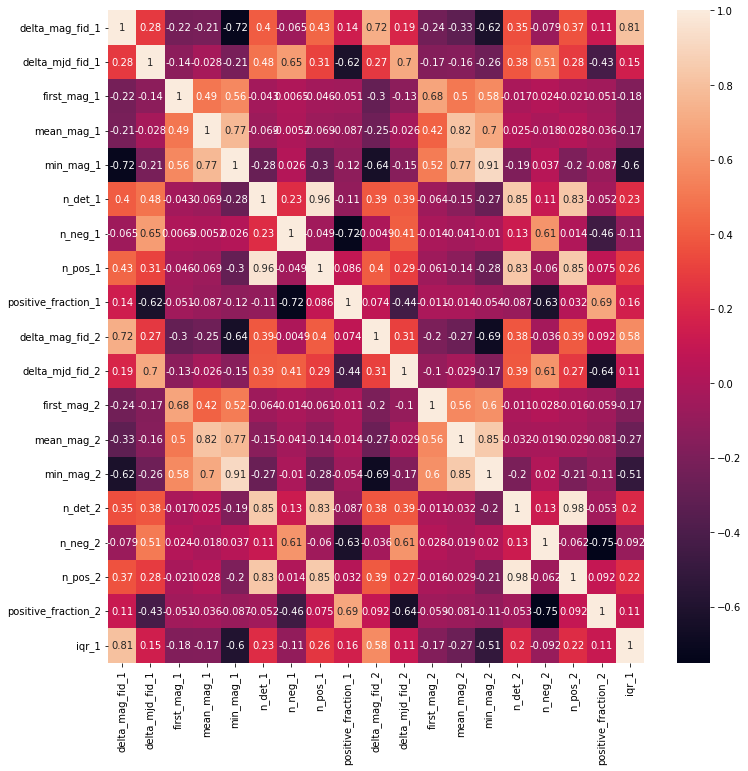

In [ ]:
import seaborn as sns

# taking all rows but only 6 columns
df_small = df.iloc[:,1:20]

correlation_mat = df_small.corr()

plt.figure(figsize=(12,12))
sns.heatmap(correlation_mat, annot = True)

plt.show()

# Analisis de componentes principales PCA: algoritmo que nos permite reducir la dimensionalidad de los datos.

Text(0, 0.5, 'Second Principal Component')

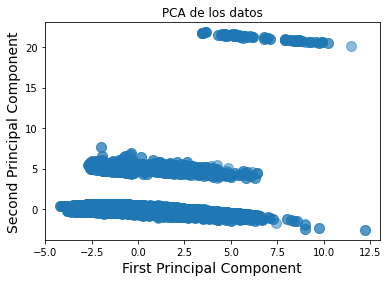

In [ ]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X = np.array(Datos_Final[['isdiffpos','magpsf','mjd','magpsf_corr','sigmapsf','sigmapsf_corr','fid','sigmapsf']])
# 'objectId','classALeRCE'
y = np.array(Datos_Final['classALeRCE'])
# Standardizing the features
x = StandardScaler().fit_transform(X)

pca = PCA()
arreglo = pca.fit_transform(x)
df = pd.DataFrame(arreglo)

fig = plt.figure()
plt.title('PCA de los datos')
fig.patch.set_facecolor('white')
plt.scatter(df[0], df[1],s=100,alpha=0.5)
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)

# Clasificación preliminar, utilizando arboles de decisión:

In [ ]:
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

In [ ]:
classifier = DecisionTreeClassifier()

#-----------------------ENTRENAMIENTO-----------------------------------------
classifier.fit(data,target_entrenamiento)


#------------------SE PRUEBA EL CLASIFICADOR----------------------------------
# predict new data:
test_sin_target = test.iloc[:,1:20]
#pues solo usaremos el target para comprobar la eficacia de la predicción
newdata = test_sin_target.to_numpy()
pred_labels = classifier.predict(newdata)


pred_labels_df = pd.DataFrame(pred_labels,columns=['pred_labels']) 
pred_labels_df.index = list(test["oid"])
pred_labels_df = pred_labels_df.reset_index()
pred_labels_df_n  = pred_labels_df.rename(columns={'index':'oid'})
comparacion_resultados = pd.merge(pred_labels_df_n, dfcrossmatches[['oid','classALeRCE']], left_on='oid', right_on='oid')
comparacion_resultados

,oid,pred_labels,classALeRCE
0,ZTF19aaleptm,SNII,SNIa
1,ZTF19aauxmqj,SNIa,SNIa
2,ZTF19aavjzwm,SNII,SNII
3,ZTF18aazblzy,SNIa,SNIa
4,ZTF18acqwdla,SNII,SNII
...,...,...,...
603,ZTF19aavkvpw,SNIa,SNIbc
604,ZTF19abimkwn,SNIa,SNIa
605,ZTF19acjerdh,SNIa,SNIa
606,ZTF19abrdliq,SNIbc,SNIa


# RESULTADOS CLASIFICACIÓN PRELIMINAR

In [ ]:
iguales = sum([comparacion_resultados['pred_labels']==comparacion_resultados['classALeRCE']])
total = iguales.shape[0] 
print('N° de aciertos usando arboles de decisión como clasificador:')
print( f'N° de aciertos: {iguales.sum()}, N° de errores: {total-iguales.sum()}')
print(f'Porcentaje de clasificaciones correctas: {"{:.2f}".format((iguales.sum()/total)*100)}% \nPorcentaje de clasificaciones incorrectas: {"{:.2f}".format(((total-iguales.sum())/total)*100)}%')

N° de aciertos usando arboles de decisión como clasificador:
N° de aciertos: 452, N° de errores: 156
Porcentaje de clasificaciones correctas: 74.34% 
Porcentaje de clasificaciones incorrectas: 25.66%


# Clasificación preliminar, utilizando arboles de decisión y un previo PCA() a los datos:
Ejemplo uso Pca antes de la clasificacion

In [ ]:
# initiate PCA and classifier
pca = PCA()
classifier_para_pca = DecisionTreeClassifier()


# transform / fit
X_transformed = pca.fit_transform(data)
classifier_para_pca.fit(X_transformed, target_entrenamiento)


DecisionTreeClassifier()

Text(0, 0.5, 'Second Principal Component')

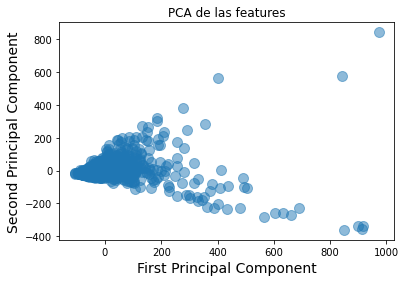

In [ ]:
#-----------------PCA DE LAS FEATURES/CARACTERISTICAS-----------------------------
graficar_pca = pd.DataFrame(X_transformed)
fig1 = plt.figure()
plt.title('PCA')
fig1.patch.set_facecolor('white')
plt.scatter(graficar_pca[0], graficar_pca[1],s=100,alpha=0.5)
plt.title("PCA de las features")
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)



In [ ]:
# transform new data using already fitted pca
# (don't re-fit the pca)
newdata_transformed = pca.transform(newdata)

# predict labels using the trained classifier

pred_labels_pca = classifier_para_pca.predict(newdata_transformed)

In [ ]:
pred_labels_df_pca = pd.DataFrame(pred_labels_pca,columns=['pred_labels']) 

In [ ]:
pred_labels_df_pca.index = list(test["oid"])
pred_labels_df_pca = pred_labels_df_pca.reset_index()
pred_labels_df_pca_n  = pred_labels_df_pca.rename(columns={'index':'oid'})
comparacion_resultados_pca = pd.merge(pred_labels_df_pca_n, dfcrossmatches[['oid','classALeRCE']], left_on='oid', right_on='oid')
comparacion_resultados_pca

,oid,pred_labels,classALeRCE
0,ZTF19aaleptm,SNIa,SNIa
1,ZTF19aauxmqj,SNIa,SNIa
2,ZTF19aavjzwm,SNII,SNII
3,ZTF18aazblzy,SNIa,SNIa
4,ZTF18acqwdla,SNIa,SNII
...,...,...,...
603,ZTF19aavkvpw,SNIa,SNIbc
604,ZTF19abimkwn,SNIa,SNIa
605,ZTF19acjerdh,SNIa,SNIa
606,ZTF19abrdliq,SLSN,SNIa


# Resultados clasificación preliminar usando previamente PCA()


In [ ]:
iguales_pca = sum([comparacion_resultados_pca['pred_labels']==comparacion_resultados_pca['classALeRCE']])
total_usando_pca = iguales_pca.shape[0] 
print('N° de aciertos usando arboles de decisión como clasificador:')
print( f'N° de aciertos: {iguales_pca.sum()}, N° de errores: {total_usando_pca-iguales_pca.sum()}')
print(f'Porcentaje de clasificaciones correctas: {"{:.2f}".format((iguales_pca.sum()/total)*100)}% \nPorcentaje de clasificaciones incorrectas: {"{:.2f}".format(((total_usando_pca-iguales_pca.sum())/total)*100)}%')

N° de aciertos usando arboles de decisión como clasificador:
N° de aciertos: 449, N° de errores: 159
Porcentaje de clasificaciones correctas: 73.85% 
Porcentaje de clasificaciones incorrectas: 26.15%
